In [1]:
import pandas as pd

df = pd.read_csv("data/processed/final.csv")

In [2]:
df["datetime"] = pd.to_datetime(df["datetime"])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df["İl"] = df["İl"].replace("K. Maras","Kahramanmaraş")

In [3]:
# Mevsimleri belirleyen fonksiyon
def get_season(month):
    if month in [12, 1, 2]:
        return "Kış"
    elif month in [3, 4, 5]:
        return "İlkbahar"
    elif month in [6, 7, 8]:
        return "Yaz"
    elif month in [9, 10, 11]:
        return "Sonbahar"
    else:
        return None

# Mevsim sütunu ekle
df['season'] = df["month"].apply(get_season)
df.head()

,Istasyon_No,İl,Istasyon_Adi,datetime,ORTALAMA_SICAKLIK_°C,t2m_min,t2m_avg,t2m_max,year,month,season
0,17372,Hatay,Antakya,1994-01-01,10.5,6.372262,9.674103,13.833467,1994,1,Kış
1,17372,Hatay,Antakya,1994-02-01,9.8,5.155581,9.135956,13.272849,1994,2,Kış
2,17372,Hatay,Antakya,1994-03-01,14.1,8.038403,12.259827,16.954649,1994,3,İlkbahar
3,17372,Hatay,Antakya,1994-04-01,18.9,13.023183,18.211945,23.714940,1994,4,İlkbahar
4,17372,Hatay,Antakya,1994-05-01,21.8,15.885092,20.883880,26.360939,1994,5,İlkbahar


# İstatistiksel Testler

## R² Testi

In [4]:
import pandas as pd
from sklearn.metrics import r2_score

def calculate_r2(df, group_cols, true_col, pred_col):
    """
    Veriyi belirtilen sütunlara göre gruplar ve R² skorlarını hesaplar.

    Parametreler:
    - df: DataFrame (pandas veri çerçevesi)
    - group_cols: list (Gruplamak istediğimiz sütunlar ["İl", "Istasyon_No", "year"] gibi)
    - true_col: str (Gerçek değerlerin bulunduğu sütun adı, örn: "ORTALAMA_SICAKLIK_°C")
    - pred_col: str (Tahmin edilen değerlerin bulunduğu sütun adı, örn: "t2m_avg")

    Döndürür:
    - r2_df: DataFrame (İlgili grupların R² skorlarını içeren tablo)
    """
    results = []

    # Gruplayarak her gruba özel R² hesapla
    for group_keys, group in df.groupby(group_cols):
        y_true = group[true_col]
        y_pred = group[pred_col]

        # En az 2 veri noktası varsa R² hesaplanabilir
        r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else None

        # Sonuçları kaydet
        result_dict = dict(zip(group_cols, group_keys))  # Gruplama değişkenlerini ekle
        result_dict["r2_score"] = r2
        results.append(result_dict)

    return pd.DataFrame(results)

In [5]:
r2_all = calculate_r2(df, group_cols=["İl", "Istasyon_No"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")
r2_yearly = calculate_r2(df, group_cols=["İl", "Istasyon_No", "year"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")
r2_seasonal = calculate_r2(df, group_cols=["İl", "Istasyon_No", "season"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")

In [6]:
# Sonucu yazdır
print(f"- İstasyonlara göre:",r2_all,sep="\n")
print("*"*50)
print(f"- İstasyonlara göre yıllık:",r2_yearly,sep="\n")
print("*"*50)
print(f"- İstasyonlara göre mevsimlik:",r2_seasonal,sep="\n")

- İstasyonlara göre:
              İl  Istasyon_No  r2_score
0          Adana        17960  0.992221
1        Antalya        17926  0.980683
2         Burdur        17892  0.987388
3          Hatay        17372  0.978353
4        Isparta        17828  0.961867
5  Kahramanmaraş        17868  0.982820
6         Mersin        17320  0.969198
7       Osmaniye        17355  0.847505
**************************************************
- İstasyonlara göre yıllık:
           İl  Istasyon_No  year  r2_score
0       Adana        17960  1994  0.995929
1       Adana        17960  1995  0.996063
2       Adana        17960  1996  0.985786
3       Adana        17960  1997  0.996715
4       Adana        17960  1998  0.996417
..        ...          ...   ...       ...
243  Osmaniye        17355  2020  0.858958
244  Osmaniye        17355  2021  0.861971
245  Osmaniye        17355  2022  0.871147
246  Osmaniye        17355  2023  0.838757
247  Osmaniye        17355  2024  0.859545

[248 rows x 4 columns]


## Yüzdesel Sapma Yöntemi

In [7]:
import pandas as pd
import numpy as np

def calculate_percentage_error(df, group_cols, true_col, pred_col):
    """
    Belirtilen gruplara göre Yüzdesel Sapma (MPE) hesaplar.

    Parametreler:
    - df: DataFrame (pandas veri çerçevesi)
    - group_cols: list (Gruplamak istediğimiz sütunlar ["İl", "Istasyon_No", "year"] gibi)
    - true_col: str (Gerçek değerlerin bulunduğu sütun adı, örn: "ORTALAMA_SICAKLIK_°C")
    - pred_col: str (Tahmin edilen değerlerin bulunduğu sütun adı, örn: "t2m_avg")

    Döndürür:
    - mpe_df: DataFrame (İlgili grupların Yüzdesel Sapma değerlerini içeren tablo)
    """
    results = []

    # Gruplama yaparak her grup için MPE hesapla
    for group_keys, group in df.groupby(group_cols):
        obs = group[true_col].values + 273.15 # Kelvin'e dönüştürüldü.
        pred = group[pred_col].values + 273.15 # Kelvin'e dönüştürüldü.

        # En az 1 veri noktası olmalı ve sıfıra bölme hatasını önleyelim
        if len(obs) > 0 and np.any(obs != 0):
            mpe = np.mean(((obs - pred) / obs) * 100)
        else:
            mpe = None  # Tüm obs değerleri sıfırsa hesaplanamaz

        # Sonuçları sakla
        result_dict = dict(zip(group_cols, group_keys))  # Grup bilgilerini ekle
        result_dict["MPE (%)"] = mpe
        results.append(result_dict)

    return pd.DataFrame(results)

In [8]:
mpe_all = calculate_percentage_error(df, group_cols=["İl", "Istasyon_No"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")
mpe_yearly = calculate_percentage_error(df, group_cols=["İl", "Istasyon_No", "year"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")
mpe_seasonal = calculate_percentage_error(df, group_cols=["İl", "Istasyon_No", "season"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")

In [9]:
# Sonucu yazdır
print(f"- İstasyonlara göre:",mpe_all,sep="\n")
print("*"*50)
print(f"- İstasyonlara göre yıllık:",mpe_yearly,sep="\n")
print("*"*50)
print(f"- İstasyonlara göre mevsimlik:",mpe_seasonal,sep="\n")

- İstasyonlara göre:
              İl  Istasyon_No   MPE (%)
0          Adana        17960  0.124972
1        Antalya        17926  0.279411
2         Burdur        17892  0.204155
3          Hatay        17372  0.230179
4        Isparta        17828  0.463277
5  Kahramanmaraş        17868  0.222730
6         Mersin        17320  0.219638
7       Osmaniye        17355  0.904830
**************************************************
- İstasyonlara göre yıllık:
           İl  Istasyon_No  year   MPE (%)
0       Adana        17960  1994 -0.025561
1       Adana        17960  1995  0.123124
2       Adana        17960  1996  0.241778
3       Adana        17960  1997 -0.027151
4       Adana        17960  1998  0.101278
..        ...          ...   ...       ...
243  Osmaniye        17355  2020  0.885812
244  Osmaniye        17355  2021  0.791280
245  Osmaniye        17355  2022  0.829154
246  Osmaniye        17355  2023  0.913173
247  Osmaniye        17355  2024  0.847778

[248 rows x 4 columns]


## Nash-Sutcliffe Efficiency (NSE)

In [10]:
import pandas as pd
import numpy as np

def calculate_nse(df, group_cols, true_col, pred_col):
    """
    Veriyi belirtilen sütunlara göre gruplar ve Nash-Sutcliffe Efficiency (NSE) skorlarını hesaplar.

    Parametreler:
    - df: DataFrame (pandas veri çerçevesi)
    - group_cols: list (Gruplamak istediğimiz sütunlar ["İl", "Istasyon_No", "year"] gibi)
    - true_col: str (Gerçek değerlerin bulunduğu sütun adı, örn: "ORTALAMA_SICAKLIK_°C")
    - pred_col: str (Tahmin edilen değerlerin bulunduğu sütun adı, örn: "t2m_avg")

    Döndürür:
    - nse_df: DataFrame (İlgili grupların NSE skorlarını içeren tablo)
    """
    results = []

    # Gruplayarak her grup için NSE hesapla
    for group_keys, group in df.groupby(group_cols):
        obs = group[true_col].values
        pred = group[pred_col].values

        # En az 2 veri noktası olmalı
        if len(obs) > 1:
            numerator = np.sum((obs - pred) ** 2)
            denominator = np.sum((obs - np.mean(obs)) ** 2)
            nse = 1 - (numerator / denominator) if denominator != 0 else None
        else:
            nse = None  # Tek veri noktası varsa hesaplanamaz

        # Sonuçları sakla
        result_dict = dict(zip(group_cols, group_keys))  # Grup bilgilerini ekle
        result_dict["NSE"] = nse
        results.append(result_dict)

    return pd.DataFrame(results)

In [11]:
nse_all = calculate_nse(df, group_cols=["İl", "Istasyon_No"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")
nse_yearly = calculate_nse(df, group_cols=["İl", "Istasyon_No", "year"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")
nse_seasonal = calculate_nse(df, group_cols=["İl", "Istasyon_No", "season"], true_col="ORTALAMA_SICAKLIK_°C", pred_col="t2m_avg")

In [12]:
# Sonucu yazdır
print(f"- İstasyonlara göre:",nse_all,sep="\n")
print("*"*50)
print(f"- İstasyonlara göre yıllık:",nse_yearly,sep="\n")
print("*"*50)
print(f"- İstasyonlara göre mevsimlik:",nse_seasonal,sep="\n")

- İstasyonlara göre:
              İl  Istasyon_No       NSE
0          Adana        17960  0.992221
1        Antalya        17926  0.980683
2         Burdur        17892  0.987388
3          Hatay        17372  0.978353
4        Isparta        17828  0.961867
5  Kahramanmaraş        17868  0.982820
6         Mersin        17320  0.969198
7       Osmaniye        17355  0.847505
**************************************************
- İstasyonlara göre yıllık:
           İl  Istasyon_No  year       NSE
0       Adana        17960  1994  0.995929
1       Adana        17960  1995  0.996063
2       Adana        17960  1996  0.985786
3       Adana        17960  1997  0.996715
4       Adana        17960  1998  0.996417
..        ...          ...   ...       ...
243  Osmaniye        17355  2020  0.858958
244  Osmaniye        17355  2021  0.861971
245  Osmaniye        17355  2022  0.871147
246  Osmaniye        17355  2023  0.838757
247  Osmaniye        17355  2024  0.859545

[248 rows x 4 columns]


# Görselleştirme

## Yüzdesel Sapma

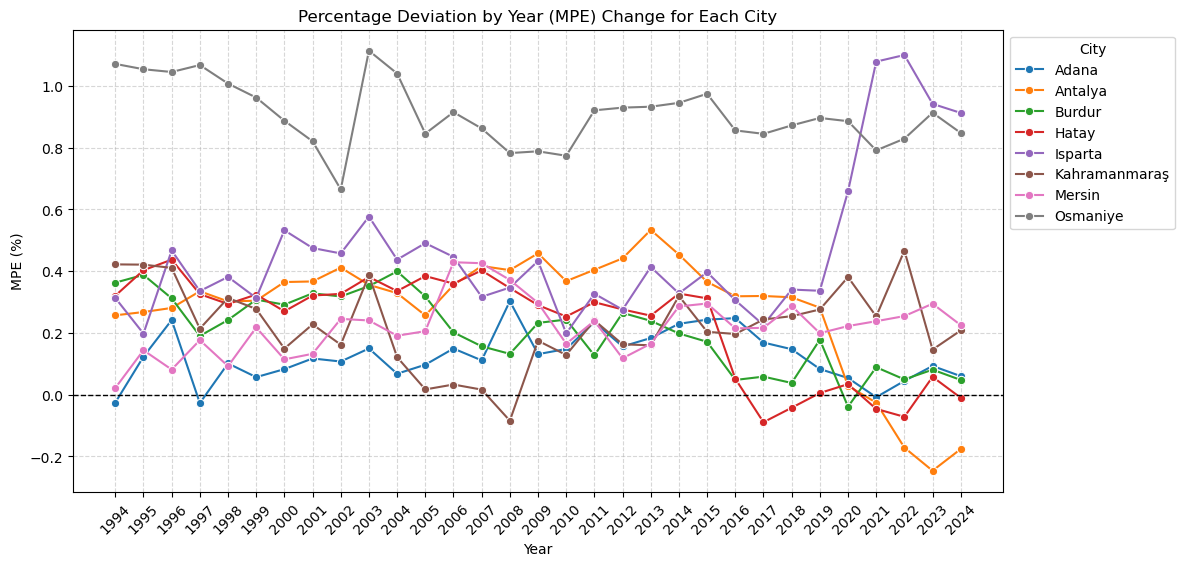

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mpe_trends(mpe_df):
    """
    Her istasyon için yıllara göre MPE (%) değişimini çizer.

    Parametreler:
    - mpe_df: DataFrame (İçinde "Istasyon_No", "year" ve "MPE (%)" sütunları olmalı)

    Çıktı:
    - Yıllara göre değişen MPE çizgilerini gösteren grafik
    """
    plt.figure(figsize=(12, 6))  # Grafik boyutu
    sns.lineplot(data=mpe_df, x="year", y="MPE (%)", hue="İl", marker="o")

    # Grafik ayarları
    plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Yatay çizgi (0 referans noktası)
    plt.xlabel("Year")
    plt.ylabel("MPE (%)")
    plt.title("Percentage Deviation by Year (MPE) Change for Each City")
    plt.xticks(np.arange(mpe_df["year"].min(), mpe_df["year"].max() + 1, 1), rotation=45)  # Yılları düzenli aralıklarla göster
    plt.legend(title="City", bbox_to_anchor=(1, 1), loc="upper left")  # Efsaneyi sağa kaydır
    plt.grid(True, linestyle="--", alpha=0.5)  # Izgara ekleyelim
    
    plt.savefig("output/figures/mpe_trends_by_year.svg", dpi=300, bbox_inches='tight')
    plt.show()
    

# Fonksiyonu çağır ve grafiği çizdir
plot_mpe_trends(mpe_yearly)


## Dağılım Grafiği

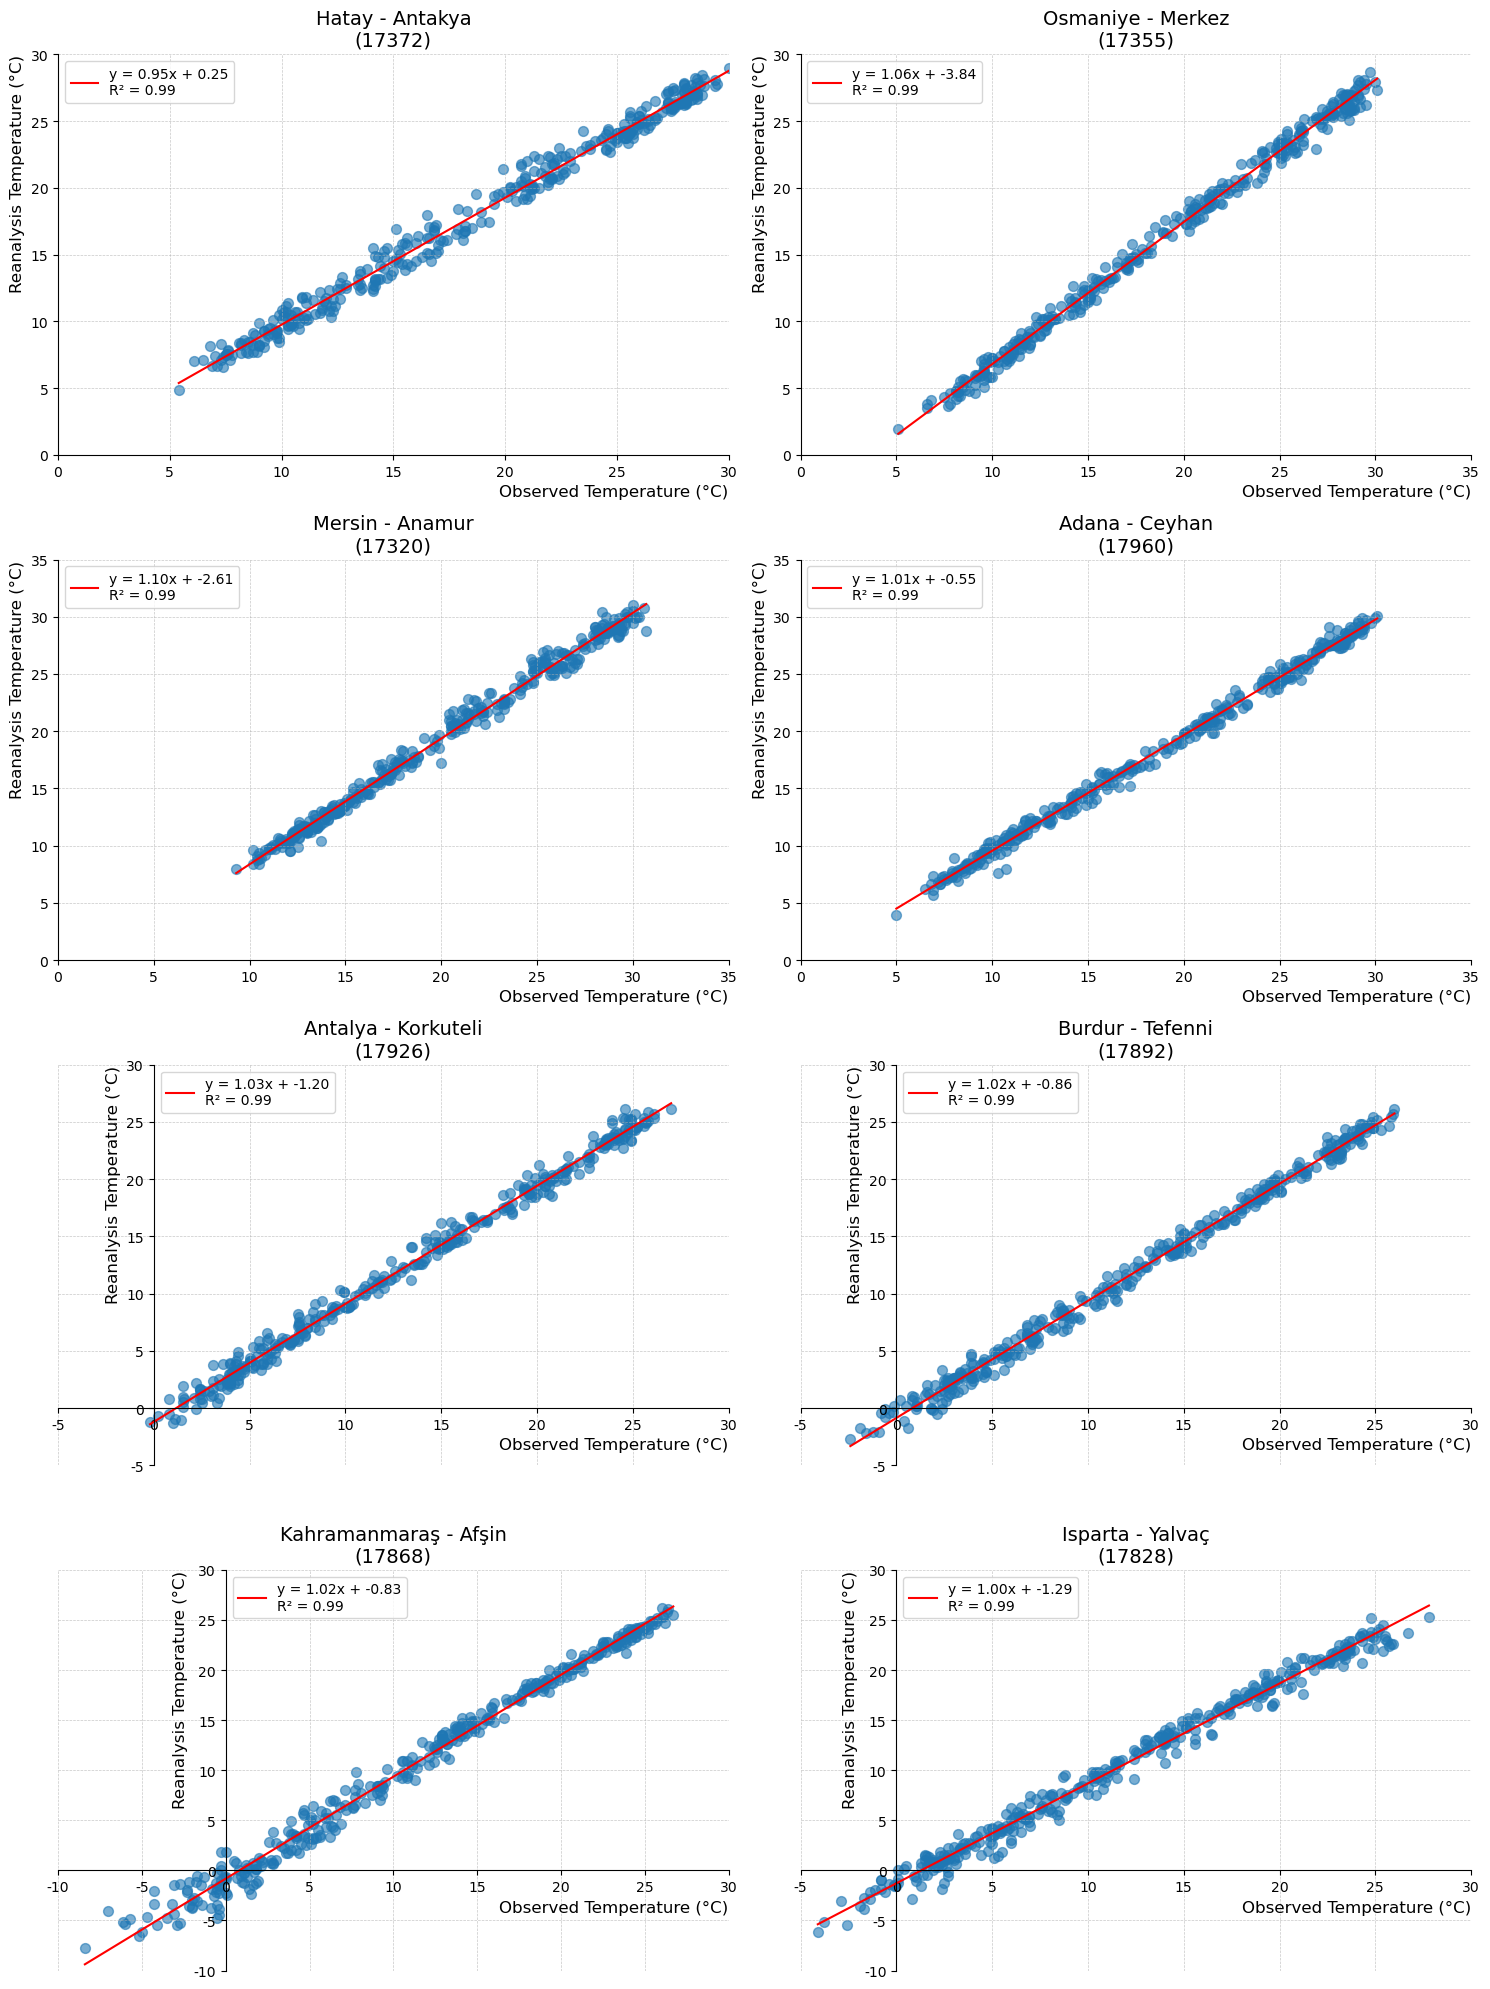

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Her bir istasyon için scatter plot ve regresyon çizgisi çizen fonksiyon
def plot_scatter_regression(df, stations):
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))

    # Farklı renkler ve işaretçiler için Seaborn paleti
    # colors = sns.color_palette("Set1", len(stations))  # Renk paletini ayarlıyoruz
    # markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', 'X']  # Farklı işaretçikler

    for ax, station in zip(axes.flatten(), stations):
        # İstasyon verisini al
        data_graph = df[df["Istasyon_No"] == station]
        
        x = data_graph["ORTALAMA_SICAKLIK_°C"].values.reshape(-1, 1)  # 2D hale getir
        y = data_graph["t2m_avg"].values  # 1D olarak bırak
        
        # Regresyon modelini oluştur ve eğit
        model = LinearRegression()
        model.fit(x, y)
        
        # Regresyon katsayıları
        slope = model.coef_[0]
        intercept = model.intercept_
        r2 = model.score(x, y)  # R² hesapla
        
        # Regresyon doğrusunu çizmek için x ekseni aralığı
        X_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(X_line)
        
        # Nokta grafiği (scatter plot) çiz
        ax.scatter(x, y, alpha=0.6, marker="o", s=50)
        
        # Regresyon doğrusunu çiz
        ax.plot(X_line, y_pred, color="red", linestyle="-", 
                label=f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}")
        
        # Koordinat eksenlerini sıfıra hizala
        ax.spines["left"].set_position("zero")
        ax.spines["bottom"].set_position("zero")
        ax.spines["right"].set_color("none")
        ax.spines["top"].set_color("none")

        # Eksen sınırlarını dinamik olarak belirle
        x_min, x_max = np.floor(x.min() / 5) * 5, np.ceil(x.max() / 5) * 5
        y_min, y_max = np.floor(y.min() / 5) * 5, np.ceil(y.max() / 5) * 5
        
        if x_min > 0:
            x_min = 0
        if y_min > 0:
            y_min = 0

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Eksen etiketleri
        ax.set_xlabel("Observed Temperature (°C)", fontsize=12, loc="right")
        ax.set_ylabel("Reanalysis Temperature (°C)", fontsize=12, loc="top")
        
        # Tik etiketleri ve aralıkları
        ax.set_xticks(np.arange(x_min, x_max + 1, 5))
        ax.set_yticks(np.arange(y_min, y_max + 1, 5))
        ax.set_xticklabels([f"{int(tick)}" for tick in ax.get_xticks()])
        ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()])

        # Başlık
        il = data_graph["İl"].unique()[0]
        istname = data_graph["Istasyon_Adi"].unique()[0]
        ax.set_title(f"{il} - {istname}\n({station})", fontsize=14, loc="center")

        # Izgara ekleme
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

        # Legend (açıklamalar)
        ax.legend(loc='upper left', bbox_to_anchor=(0, y_max), bbox_transform=ax.transData)

    plt.tight_layout()
    plt.savefig("output/figures/temperature_scatter_regression_plots.svg", dpi=300, bbox_inches='tight')
    plt.show()

# Veri setindeki her bir istasyon numarasını alalım
# stations = df["Istasyon_No"].unique()
stations = [17372,17355,17320,17960,17926,17892,17868,17828]

# Fonksiyonu çağır
plot_scatter_regression(df, stations)


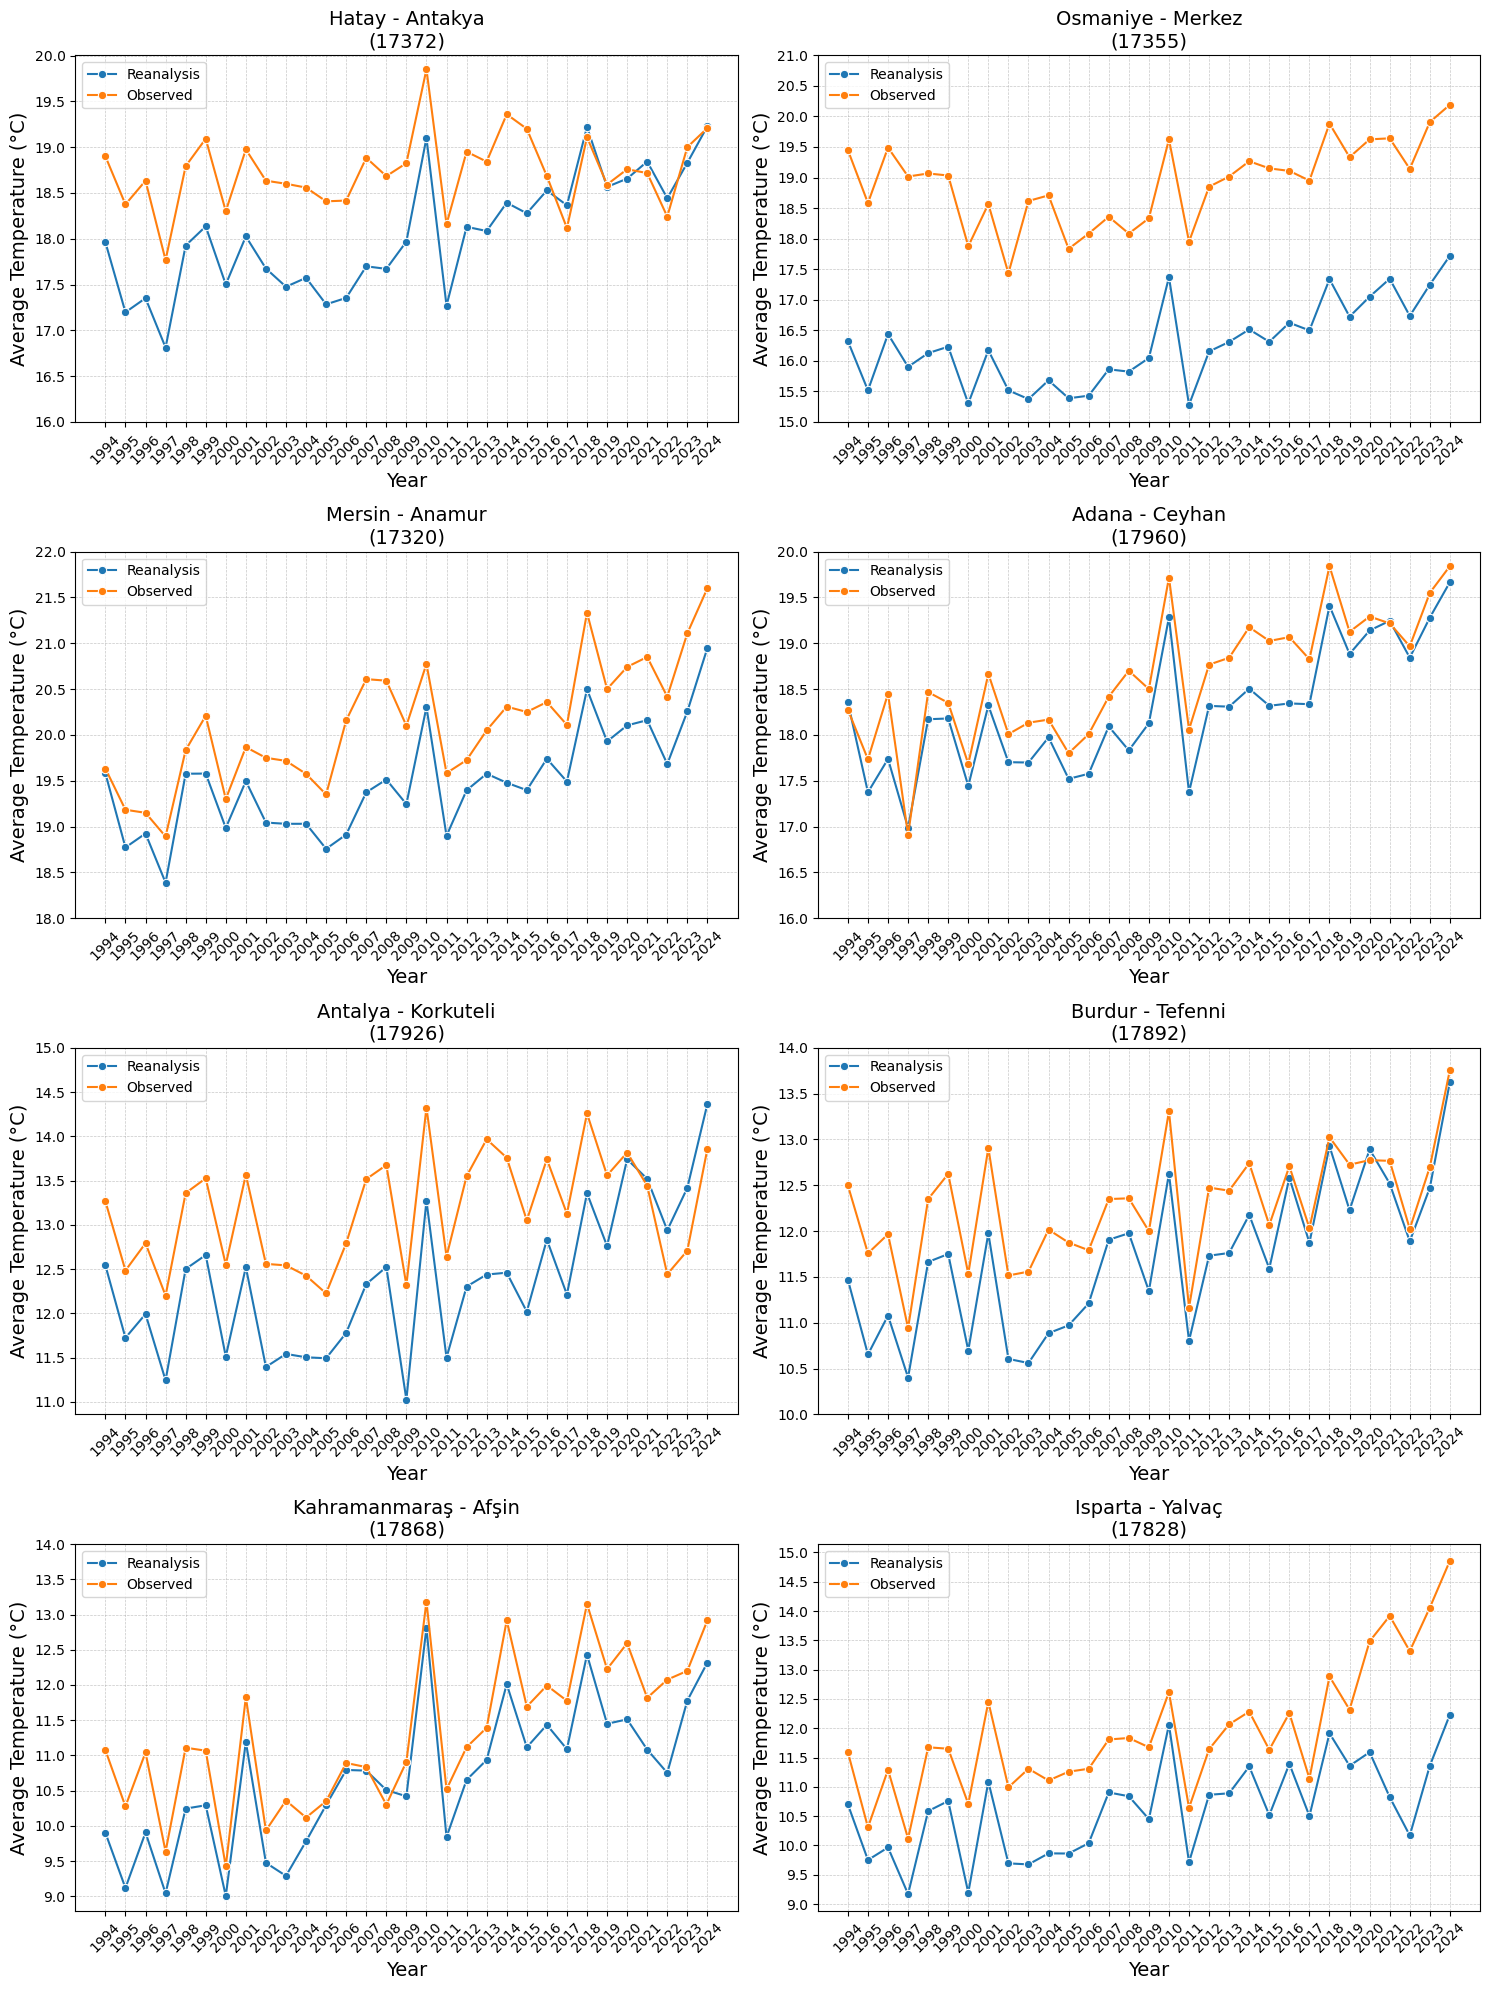

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Yıllık ortalamayı hesapla
df['year'] = df['datetime'].dt.year  # 'datetime' sütunundan yıl bilgisi çıkarılıyor
annual_mean = df.groupby(['İl', 'Istasyon_No', 'Istasyon_Adi', 'year'])[['ORTALAMA_SICAKLIK_°C', 't2m_avg']].mean().reset_index()

# İl bazında unique isimler
# stations = annual_mean['İl'].unique()
stations = [17372,17355,17320,17960,17926,17892,17868,17828]

# Grafik için figür ayarları
fig, axes = plt.subplots(4,2, figsize=(15, 20))

# Eğer sadece bir il varsa, axes dizisini düzelt
if len(stations) == 1:
    axes = [axes]

# Grafiklerin her birini oluşturuyoruz
for ax, station in zip(axes.flatten(), stations):
    data_graph = annual_mean[annual_mean["Istasyon_No"] == station]
    
    x = data_graph["year"]
    y = data_graph["t2m_avg"]
    z = data_graph["ORTALAMA_SICAKLIK_°C"]
    
    # Hem 'ORTALAMA_SICAKLIK_°C' hem de 't2m_avg' için yıllık ortalamaları çiz
    sns.lineplot(data=data_graph, x=x, y=y, label='Reanalysis', ax=ax, marker='o')
    sns.lineplot(data=data_graph, x=x, y=z, label='Observed', ax=ax, marker='o')

    # Eksen etiketleri ve başlık
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Average Temperature (°C)", fontsize=14)
    
    # Yıllar için xticks
    ax.set_xticks(np.arange(data_graph["year"].min(), data_graph["year"].max() + 1, 1))
    ax.set_xticklabels(np.arange(data_graph["year"].min(), data_graph["year"].max() + 1, 1), rotation=45)  # Yılları düzenli aralıklarla göster

    # Y eksenini 0.5'lik adımlarla ayarla
    y_min = min(y.min(), z.min())  # En düşük sıcaklık değeri
    y_max = max(y.max(), z.max())  # En yüksek sıcaklık değeri
    y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 0.5, 0.5)  # 0.5'lik adımlarla tik oluştur
    ax.set_yticks(y_ticks)
    
    # Başlık
    il = data_graph["İl"].unique()[0]
    istname = data_graph["Istasyon_Adi"].unique()[0]
    ax.set_title(f"{il} - {istname}\n({station})", fontsize=14, loc="center")

    # Efsane (legend) ayarları
    ax.legend(loc='upper left')

    # Grafik ızgarası
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Ekranda düzgün görünmesi için layout'u ayarla
plt.tight_layout()

# Görseli ekrana çizme
plt.show()

# Grafiklerin kaydedilmesi
plt.savefig("output/figures/annual_temperature_comparison_by_station.svg", dpi=300)


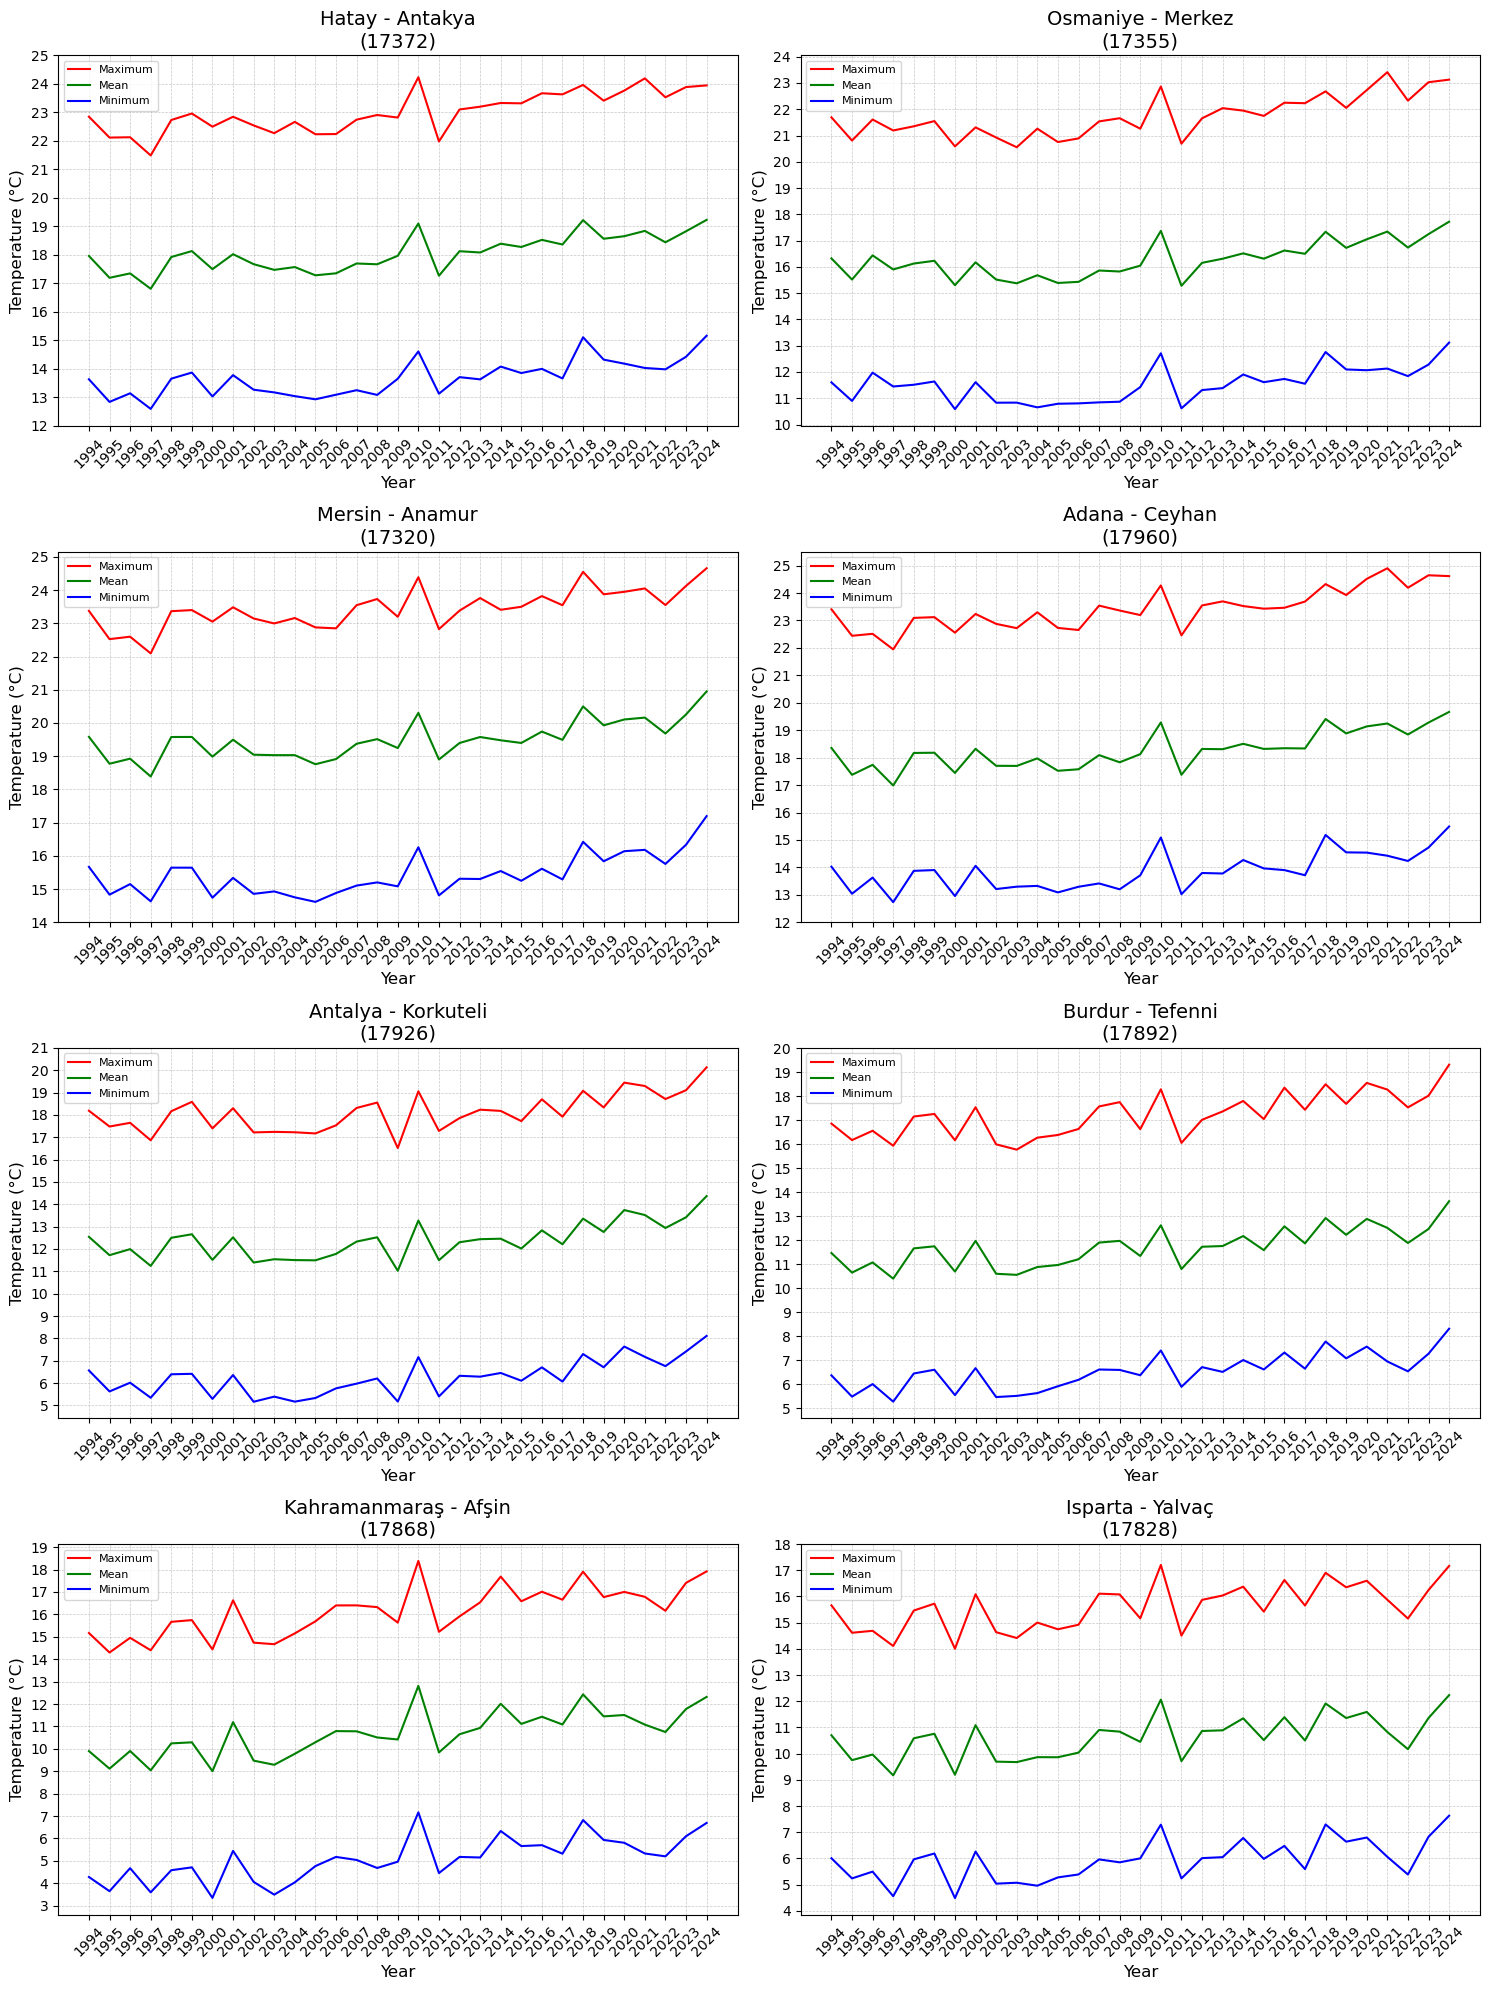

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# İstasyon ve yıl bazında gruplama ve ortalama alma
yearly_avg = df[["Istasyon_No", "Istasyon_Adi", "İl", "year", "t2m_min", "t2m_avg", "t2m_max"]] \
    .groupby(["Istasyon_No", "Istasyon_Adi", "İl", "year"]).mean().reset_index()

# İstasyonlar
stations = [17372, 17355, 17320, 17960, 17926, 17892, 17868, 17828]

# Grafik hazırlığı
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# İstasyonlar için grafikleri çizme
for ax, station in zip(axes.flatten(), stations):
    data_graph = yearly_avg[yearly_avg["Istasyon_No"] == station]
    
    x = data_graph["year"]
    min_values = data_graph["t2m_min"]
    mean_values = data_graph["t2m_avg"]
    max_values = data_graph["t2m_max"]
    
    # Minimum, ortalama ve maksimum sıcaklıkları çiz
    ax.plot(x, max_values, label="Maximum", color="red")
    ax.plot(x, mean_values, label="Mean", color="green")
    ax.plot(x, min_values, label="Minimum", color="blue")

    # X eksenini düzenle (yıl bazında)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation=45, fontsize=10)

    # Y eksenini 0.5'lik adımlarla ayarla
    y_min = min(min_values.min(), mean_values.min(), max_values.min())
    y_max = max(min_values.max(), mean_values.max(), max_values.max())
    y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1)
    ax.set_yticks(y_ticks)
    
    # Y ekseni etiketleri
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    
    # X ekseni etiketleri
    ax.set_xlabel("Year", fontsize=12)

    # Başlık
    il = data_graph["İl"].unique()[0]
    istname = data_graph["Istasyon_Adi"].unique()[0]
    ax.set_title(f"{il} - {istname}\n({station})", fontsize=14, loc="center")

    # Legend ekleme
    ax.legend(loc="upper left", fontsize=8)

    # Izgara
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Layout düzenlemesi
plt.tight_layout()

# Grafiği kaydetme ve gösterme
plt.savefig("output/figures/yearly_temperature_min_mean_max_trends.svg", dpi=300)
plt.show()
